# TensorFlow 邏輯回歸網路 手寫數字分類
---

## 目標：
* 了解圖像資料處理步驟
* 建立tensorflow softmax regression model
* 訓練model並計算出準確度

# 索引
## [1 圖像資料預處理](#1.-圖像資料預處理)   
[1.1 讀取標籤及位置](#1.1-讀取標籤及位置)   
[1.2 資料檢查](#1.2-資料檢查)   
* [1.2.1 檢查資料是否平衡](#1.2.1-檢查資料是否平衡)
* [1.2.2 檢查資料內容](#1.2.2-檢查資料內容)   

[1.3 將資料切成 train 70%, val 10%, test 20%](#1.3-將資料分成三等份)   
[1.4 讀取及轉換資料](#1.4-讀取及轉換資料)   
[1.5 目標變數轉換](#1.5-目標變數轉換)
## [2 模型建置](#2.-模型建置)   
[2.1 推測](#2.1-推測)  
[2.2 誤差](#2.2-誤差)  
[2.3 訓練](#2.3-訓練)  
[2.4 評估](#2.4-評估)  
[2.5 小批次梯度下降](#2.5-小批次梯度下降)  
[2.6 模型訓練](#2.6-模型訓練)  
## [3 使用TensorBoard視覺化工具](#3.-使用TensorBoard視覺化工具)   



In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os, cv2

## 1. 圖像資料預處理
### 1.1 讀取標籤及位置
當我們面對的是圖像資料，或者其他非結構化的資料時，由於其特性的關係，通常並不是直接使用資料表的形式儲存。  
所以我們可能會依照不同的類別，存放在不同的資料夾中（也就是我們用資料夾來分類）。  
在這種情況下，我們需要熟悉如何一次掃描整個資料夾內的子資料夾，並抓取我們需要的資訊。

In [2]:
def filePathsGen(rootPath):
    '''獲取該輸入目錄底下的資料，並將其子目錄作為其類別標籤（適用於子目錄名稱僅含有一個位元字）'''
    paths=[]
    labels=[]
    
    for dirPath,dirNames,fileNames in os.walk(rootPath):
        for fileName in fileNames:
            
            # 將完整目錄存在 paths 變數中
            paths.append( os.path.join(dirPath,fileName) )
            
            # 將所在目錄存在 labels 變數中
            if os.name == 'nt':
                label = dirPath.split('\\')[-1]
            else:
                label = dirPath.split('/')[-1]
            labels.append( label )
            
    # 回傳時將資料轉為 numpy array 這是python很好用的函式庫，速度快，而且大多數函式庫都依賴它
    return np.array(labels), np.array(paths)

In [3]:
labels, paths = filePathsGen('datasets/mnist')

### 1.2 資料檢查
#### 1.2.1 檢查資料是否平衡
每當我們拿到新的資料時，一定要做這個步驟。   
即使每分資料或許不同，但是檢查是否平衡、缺值等，都是必要的。

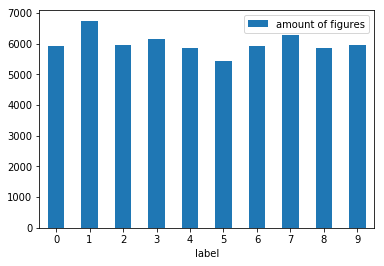

In [4]:
# 檢查資料是否平衡，先將剛剛獲得的 paths, labels 合併在一個 DataFrame 中
df = pd.concat( [pd.Series(labels), pd.Series(paths)], axis=1 )
df.columns = ['label', 'path'] # 給資料欄位名稱
df = df.sample(frac=1) # 將資料打亂
df = df.reset_index().drop('index', axis=1) # 打亂後重設 index

# 藉著 DataFrame 的 groupby 功能, 我們可以快速取得每一個類別的筆數
dfCount = df.groupby('label').count()

# 試著讓圖示符合我們真正想要看到的內容
dfCount.rename( columns={'path':'amount of figures'}, inplace=True )

# 指定圖表樣式為條狀圖, rot是底下的標籤顯示方向（可有可無）
dfCount.plot(kind='bar', rot=0)

#### 1.2.2 檢查資料內容
資料檢查第二步，我們隨便挑個幾張圖出來看，這是要檢查我們的資料是否符合我們的期待。  
由於有的時候資料並不是我們自己蒐集的，又或者我們自己蒐集時沒有檢查，所以這個步驟千萬不要省。  

由於上面我們已經順手將`DataFrame`打亂了。  
所以我們就不用特地隨機抽取圖片，直接看前5張圖。

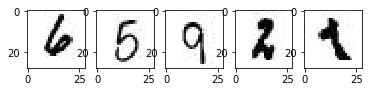

In [5]:
# 要讓繪圖區分割橫向，就需要設定子圖
fig, axes = plt.subplots(1, 5) # 設定圖片分配為 1*5

for i in range(5):
    # 用 opencv 來讀取圖片
    img = cv2.imread(df.path[i])
    
    # 在相應的子圖區域繪圖
    axes[i].imshow(img)
    
# 貌似新版 jupyter notebook 已經不需要自己打上 show()方法
# 但是養成好習慣，在想要繪圖的時候還是加上。
plt.show()

### 1.3 將資料分成三等份
這邊由於我們是平衡的資料，所以事實上我們是可以直接切的（剛剛也已經打亂）。  
但是如果是不平衡資料的話，還需要另外處理。

In [6]:
# 取出 path, label 存成 X 跟 y
# 記得存成 numpy array 這樣資料就不含有原本的 index
X = np.array(df.path)
y = np.array(df.label).astype(np.int8)

In [7]:
def sliceDatasets(X, y):
    # 設定 0.7*0.1*0.2 的 index 範圍
    train_idx = range( 0, int(0.7*len(X)) )
    val_idx = range( int(0.7*len(X)), int(0.8*len(X)) )
    test_idx = range( int(0.78*len(X)), len(X)-1 )
    
    # 將 X, y 切成我們需要的三分 
    X_train = X[train_idx]
    X_val = X[val_idx]
    X_test = X[test_idx]
    y_train = y[train_idx]
    y_val = y[val_idx]
    y_test = y[test_idx]
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [8]:
X_train, X_val, X_test, y_train, y_val, y_test = sliceDatasets(X, y)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(42000,) (42000,)
(6000,) (6000,)
(13199,) (13199,)


### 1.4 讀取及轉換資料
由於我們的資料是圖片，通常比較占用記憶體，會選擇在前面都處理好後才真的讀進記憶體內。   
這在圖片數量很多、圖片很大甚至影片的時候會非常有感。

In [9]:
def dataLoad(X):
    '''此方法透過輸入指定的目錄向量，讀取目錄的圖檔。'''
    
    # 先創建 numpy array 這種做法需要先設定大小，但是效能比起 python 原生 list 快非常多
    x=np.zeros( (len(X), 28, 28) )
    
    # 逐筆讀取資料後取代本來創建的 numpy array
    for i in range(len(X)):
        # 在 imread() 方法內帶入參數 flag=0 表示讀取灰階圖片
        # 讀取後將數值除255, 這會讓每個數值介於 0~1 之間, 方便我們後續機器做運算
        x[i]=cv2.imread(X[i],0)/255 
        
    return x

In [10]:
# 將剛剛的路徑資料全都讀取成圖片資料
X_train = dataLoad(X_train)
X_val = dataLoad(X_val)
X_test = dataLoad(X_test)

print(X_train.shape, X_val.shape, X_test.shape)

(42000, 28, 28) (6000, 28, 28) (13199, 28, 28)


In [11]:
# 由於我們目標是使用簡單的 softmax 來實現分類, 因此我們把資料展開, 方便我們建模
# 透過 reshape()方法, 將資料從二維的 28x28 轉為一維的 784
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

print(X_train.shape, X_val.shape, X_test.shape)

(42000, 784) (6000, 784) (13199, 784)


### 1.5 目標變數轉換
深度學習最終的輸出, 是需要對應目標變數的。  
由於我們最終需要10個節點, 分別代表 0~9 的分類預測, 因此傳進模型的 y 也必須要有 0~9。   
如果不想自己定義方法也可以使用套件提供的方法轉成one hot型態。

In [12]:
def to_one_hot(data, num_labels=10):
    '''此方法用於手寫數字的標籤轉 one hot 型態'''
    
    # 同樣, 我們先建立全部為零的 numpy array
    one_hot = np.zeros( (data.shape[0], num_labels) )
    
    # 透過 enumerate 可以拿到當前資料的內容跟索引
    for i, j in enumerate(data):
        # 將指定的索引的第 y 欄改成 1
        one_hot[i][j] = 1
    return one_hot

In [13]:
y_train = to_one_hot(y_train)
y_val = to_one_hot(y_val)
y_test = to_one_hot(y_test)

print(y_train.shape, y_val.shape, y_test.shape)

(42000, 10) (6000, 10) (13199, 10)


到這邊，我們已經完成了數據的前處理，複習一下前面做了些什麼：  
* 使用`os`讀取了指定目錄以下全部的檔案, 設定了子目錄名稱作為目標標籤
* 使用`pandas`檢查了資料的平衡性
* 使用`opencv`查看了資料本身
* 使用`numpy`切成了三個部分的資料集, 分別是`train 70%`, `validation 10%`, `test 20%`
* 使用`opencv`讀取了所有的圖檔, 並轉成灰階, 處理至0~1之間
* 使用`numpy`將資料展開成一維
* 使用`numpy`將目標做成了one hot格式
---

## 2. 模型建置
完成了數據的處理後, 我們真正能夠進入到建模以及訓練的步驟。  
整個建模的過程將會分成以下四個部分：  
* *`推測 (inference)`*: 計算輸入的資料, 算出對應不同類別輸出的機率分布
* *`誤差 (loss)`*: 計算誤差函數的值, 這邊用交叉嫡作為誤差函數
* *`訓練 (training)`*: 計算模型參數的梯度並更新
* *`評估 (evaluate)`*: 判斷模型的有效性

### 2.1 推測

In [14]:
def inference(x):
    '''定義推測的步驟, 傳入一筆或多筆資料, 使用softmax計算出其分類標籤'''
    
    # 定義變數初始化方法, 直接填值為零
    init = tf.constant_initializer(value=0)
    
    # 獲取變數的值, 首個參數指定要拿哪個變數
    w = tf.get_variable('w', [784,10], initializer=init)
    b = tf.get_variable('b', [10], initializer=init)
    
    # 產出的公式為 softmax(x*w + b)
    output = tf.nn.softmax( tf.matmul(x, w) + b )
    
    # 紀錄過程
    w_hist = tf.summary.histogram('weights', w)
    b_hist = tf.summary.histogram('biases', b)
    y_hist = tf.summary.histogram('output', output)
    
    return output

### 2.2 誤差

In [15]:
def loss(output, y):
    '''定義誤差函數計算的步驟, 這邊使用的是交叉嫡'''
    
    # 計算每一個輸出的誤差, 這時候的誤差shape應該為[batch_size, 10], 也就是每一筆有10個誤差值
    dot_product = y * tf.log(output)
    
    # 沿著方向為 1 的方向降維, 也就是把 d1 維度壓扁, 這時候誤差的shape變為[batch_size, 1]
    xentropy = -tf.reduce_sum(dot_product, reduction_indices=1)
    
    # 沿著方向為 0 的方向降為, 也就是把 d0 維度壓扁, 這時候誤差的shape終於變成[1]
    loss = tf.reduce_mean(xentropy)
    
    return loss

### 2.3 訓練

In [16]:
def training(cost, global_step, lr):
    '''定義訓練的步驟, 用梯度下降法'''
    
    # 紀錄過程
    tf.summary.scalar('cost', cost)
    
    # 定義訓練的方法, 使用梯度下降法
    optimizer = tf.train.GradientDescentOptimizer(lr)
    
    # 進行誤差最小化任務
    train_op = optimizer.minimize(cost, global_step=global_step)
    
    return train_op

### 2.4 評估

In [17]:
def evaluate(output, y):
    '''定義評估的方式, 輸入標籤以及預測標籤, 輸出準確率'''
    
    # 找出標籤與預測標籤的最大信心水準, 比較是否相同
    correct_prediction = tf.equal( tf.argmax(output, 1), tf.argmax(y, 1) )
    
    # 沿著 0 維度降維, 算出一個準確率
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # 紀錄過程
    tf.summary.scalar('validation_error', (1. - accuracy))
    
    return accuracy

### 2.5 小批次梯度下降
到這邊其實我們已經完成模型設計的大部分工作了。   
但是甚至如果我們使用的是**批次梯度下降**, 也就是整個批次丟進模型訓練的演算法,   
那麼我們直接開始就可以, 但是批次梯度下降有著不小的問題, 因此我們還是寫一下簡單的小批次

In [18]:
def next_batch(batch_size, data, labels):
    '''定義批次輸入的方法'''
    
    # 獲取索引並打亂
    idx=np.arange(0, len(data))
    np.random.shuffle(idx)
    
    # 打亂後只取開頭一個批次的資料量
    idx = idx[:batch_size]
    
    # 取得一個批次數量的data, label並回傳
    data_shuffle = data[idx]
    labels_shuffle = labels[idx]

    return data_shuffle, labels_shuffle

### 2.6 模型訓練

In [19]:
# 定義模型所需參數
lr = 0.01
epochs = 500
batch_size = 2048
display_step = 1

In [20]:
# 開啟新的圖(graph), 這樣會在結束運算後自動關閉
# 僅因測試使用, 方便釋放資源以及模型自動清空, 重新執行才不會出現已經存在的錯誤
# 如果需要保存變數資料, 請不要使用這個語法
with tf.Graph().as_default() as g:
    # 設定 x, y 的佔位符, 這樣可以因應不同情況做替換
    x = tf.placeholder('float', [None, 784])
    y = tf.placeholder('float', [None, 10])

    # 初始化從零開始, 計算目前訓練的次數
    global_step = tf.Variable(0, name='global_step', trainable=False)

    # 呼叫上方定義的四個模型組成要素
    output = inference(x)
    cost = loss(output, y)
    train_op = training(cost, global_step, lr)
    eval_op = evaluate(output, y)
    
    # 設定儲存節點跟目標資料夾
    summary_op = tf.summary.merge_all()
    saver = tf.train.Saver()
    summary_writer = tf.summary.FileWriter('logs/simple_logistic_model/', graph=g)

    # 開啟會話, 進行變數的初始化.
    init_op = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init_op)

    # 開始訓練, 這個迴圈會重複進行直到訓練結束
    for epoch in range(epochs):

        # 由於是小批次訓練, 這邊設定了每個epoch會更新的次數
        total_batch = int( len(X_train)/batch_size )
        
        for i in range(total_batch):
            # 呼叫上方定義的小批次傳入方法, 取得當前的 (x, y)
            mbatch_x, mbatch_y = next_batch(batch_size, X_train, y_train)
            # 由會話開啟訓練, 由於我們使用了placeholder, 所以feed_dict是一定要給的
            sess.run(train_op, feed_dict={x:mbatch_x, y:mbatch_y})

        # 呼叫評估方法, 計算出train, val的準確度, 印出誤差
        train_accuracy = sess.run(eval_op, feed_dict={x:X_train, y:y_train})
        val_accuracy = sess.run(eval_op, feed_dict={x:X_val, y:y_val})
        print('Epoch:', '%04d' % (epoch+1), 'Train Error:', (1-train_accuracy), 'Validation Error:', (1-val_accuracy))
        
        # 執行我們設定的紀錄節點, 並把結果寫到指定的資料夾
        summary_str = sess.run(summary_op, feed_dict={x:mbatch_x, y:mbatch_y})
        summary_writer.add_summary(summary_str, sess.run(global_step))
        saver.save(sess, 'logs/simple_logistic_model/model-checkpoint', global_step=global_step)

    # 結束
    print('Optimization Finished!')
    
    # 呼叫評估方法, 計算test資料準確度並印出
    accuracy = sess.run(eval_op, feed_dict={x:X_test, y:y_test})
    print('Test Accuracy:', accuracy)

Epoch: 0001 Train Error: 0.509261906147 Validation Error: 0.496333360672
Epoch: 0002 Train Error: 0.348666667938 Validation Error: 0.351166665554
Epoch: 0003 Train Error: 0.3107380867 Validation Error: 0.307166695595
Epoch: 0004 Train Error: 0.262928545475 Validation Error: 0.252166688442
Epoch: 0005 Train Error: 0.247904777527 Validation Error: 0.239166676998
Epoch: 0006 Train Error: 0.241500020027 Validation Error: 0.234833359718
Epoch: 0007 Train Error: 0.225428581238 Validation Error: 0.219166696072
Epoch: 0008 Train Error: 0.20526188612 Validation Error: 0.199000000954
Epoch: 0009 Train Error: 0.205404758453 Validation Error: 0.199333310127
Epoch: 0010 Train Error: 0.202285706997 Validation Error: 0.196833312511
Epoch: 0011 Train Error: 0.197857141495 Validation Error: 0.194500029087
Epoch: 0012 Train Error: 0.18719047308 Validation Error: 0.181166648865
Epoch: 0013 Train Error: 0.193190455437 Validation Error: 0.186500012875
Epoch: 0014 Train Error: 0.182904779911 Validation Erro

Epoch: 0114 Train Error: 0.120595216751 Validation Error: 0.116999983788
Epoch: 0115 Train Error: 0.120190501213 Validation Error: 0.117333352566
Epoch: 0116 Train Error: 0.119857132435 Validation Error: 0.116833329201
Epoch: 0117 Train Error: 0.119595229626 Validation Error: 0.116666674614
Epoch: 0118 Train Error: 0.119023799896 Validation Error: 0.116666674614
Epoch: 0119 Train Error: 0.119904756546 Validation Error: 0.11533331871
Epoch: 0120 Train Error: 0.118476212025 Validation Error: 0.116333305836
Epoch: 0121 Train Error: 0.118976175785 Validation Error: 0.115166664124
Epoch: 0122 Train Error: 0.119619071484 Validation Error: 0.114499986172
Epoch: 0123 Train Error: 0.119023799896 Validation Error: 0.115166664124
Epoch: 0124 Train Error: 0.118238091469 Validation Error: 0.115999996662
Epoch: 0125 Train Error: 0.118047595024 Validation Error: 0.114333331585
Epoch: 0126 Train Error: 0.118047595024 Validation Error: 0.115000009537
Epoch: 0127 Train Error: 0.117690503597 Validation E

Epoch: 0227 Train Error: 0.107476174831 Validation Error: 0.105333328247
Epoch: 0228 Train Error: 0.1071190238 Validation Error: 0.104666650295
Epoch: 0229 Train Error: 0.107714295387 Validation Error: 0.105333328247
Epoch: 0230 Train Error: 0.107333362103 Validation Error: 0.106166660786
Epoch: 0231 Train Error: 0.107452392578 Validation Error: 0.106500029564
Epoch: 0232 Train Error: 0.107476174831 Validation Error: 0.106166660786
Epoch: 0233 Train Error: 0.106714308262 Validation Error: 0.103166639805
Epoch: 0234 Train Error: 0.106785714626 Validation Error: 0.103833317757
Epoch: 0235 Train Error: 0.106904745102 Validation Error: 0.103999972343
Epoch: 0236 Train Error: 0.107261896133 Validation Error: 0.103833317757
Epoch: 0237 Train Error: 0.10692858696 Validation Error: 0.103999972343
Epoch: 0238 Train Error: 0.106476187706 Validation Error: 0.104333341122
Epoch: 0239 Train Error: 0.106380939484 Validation Error: 0.103999972343
Epoch: 0240 Train Error: 0.106904745102 Validation Err

Epoch: 0340 Train Error: 0.101523816586 Validation Error: 0.098833322525
Epoch: 0341 Train Error: 0.10159522295 Validation Error: 0.0986666679382
Epoch: 0342 Train Error: 0.101857125759 Validation Error: 0.0983333587646
Epoch: 0343 Train Error: 0.101357161999 Validation Error: 0.0981666445732
Epoch: 0344 Train Error: 0.101333320141 Validation Error: 0.0981666445732
Epoch: 0345 Train Error: 0.101619064808 Validation Error: 0.0986666679382
Epoch: 0346 Train Error: 0.101571440697 Validation Error: 0.0981666445732
Epoch: 0347 Train Error: 0.10128569603 Validation Error: 0.0991666913033
Epoch: 0348 Train Error: 0.101214289665 Validation Error: 0.0981666445732
Epoch: 0349 Train Error: 0.101476192474 Validation Error: 0.0983333587646
Epoch: 0350 Train Error: 0.101380944252 Validation Error: 0.0981666445732
Epoch: 0351 Train Error: 0.101047635078 Validation Error: 0.0985000133514
Epoch: 0352 Train Error: 0.101428568363 Validation Error: 0.098833322525
Epoch: 0353 Train Error: 0.101000010967 Va

Epoch: 0451 Train Error: 0.0978095531464 Validation Error: 0.0953333377838
Epoch: 0452 Train Error: 0.0977619290352 Validation Error: 0.0953333377838
Epoch: 0453 Train Error: 0.0974524021149 Validation Error: 0.0956666469574
Epoch: 0454 Train Error: 0.0974761843681 Validation Error: 0.0954999923706
Epoch: 0455 Train Error: 0.0977380871773 Validation Error: 0.0958333611488
Epoch: 0456 Train Error: 0.0977619290352 Validation Error: 0.0958333611488
Epoch: 0457 Train Error: 0.0978809595108 Validation Error: 0.096499979496
Epoch: 0458 Train Error: 0.0978333353996 Validation Error: 0.0958333611488
Epoch: 0459 Train Error: 0.0972619056702 Validation Error: 0.0960000157356
Epoch: 0460 Train Error: 0.0971904993057 Validation Error: 0.0954999923706
Epoch: 0461 Train Error: 0.0974524021149 Validation Error: 0.0953333377838
Epoch: 0462 Train Error: 0.0976666808128 Validation Error: 0.095166683197
Epoch: 0463 Train Error: 0.0976666808128 Validation Error: 0.0956666469574
Epoch: 0464 Train Error: 0.

到這裡為止，整個簡單的模型就已經完成了，我們再來複習一下剛剛的操作：  
* 定義了**推測**的方法, 因此我們可以從圖片的向量中推測其分類
* 定義了**誤差**的方法, 這讓我們計算估計值與實際值的差距
* 定義了**訓練**的方法, 透過訓練我們可以降低我們的誤差
* 定義了**評估**的方法, 這使我們得以隨時檢查模型是否合適
* 使用了**小批次**訓練, 隨機輸入資料, 這可以避免整批梯度無法下降的問題
* 經由反覆執行上面定義的內容, 我們終於訓練出一個簡單模型, 並且在test資料準確率達九成

---

## 3. 使用TensorBoard視覺化工具

還記不記得，在很多步驟中我們加入了記錄過程的運算結點。  
我們還在每次梯度後把log檔寫出，卻沒有看到結果。  
事實上我們可以使用tensorflow所提供的視覺化套件來快速查看它們。  
首先先打開anaconda prompt並輸入 `tensorboard --logdir=<absolute_path_to_log_dir>`  
注意`<absolute_path_to_log_dir>`是按照剛剛設定的目錄，但是要全路徑哦。  
輸入完成只要看到它回傳了一個網址並提示CTRL+C離開，這時候就成功打開了`tensorboard`這個視覺化套件。  

![cmd](image/cmd.jpg)

連上它所提供的網址，就可以看到我們剛剛設定的cost, validation_error  
甚至按下graphs還可以看到完整節點圖  

![cost](image/cost.jpg)

![node](image/node.png)